In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.io import loadmat


import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

from vgg_model import*

%matplotlib inline

In [3]:
print(tf.__version__)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

1.14.0


In [4]:
image_height = 300 
image_width = 400
color_channels = 3

Text(0.5, 1.0, 'Style Image')

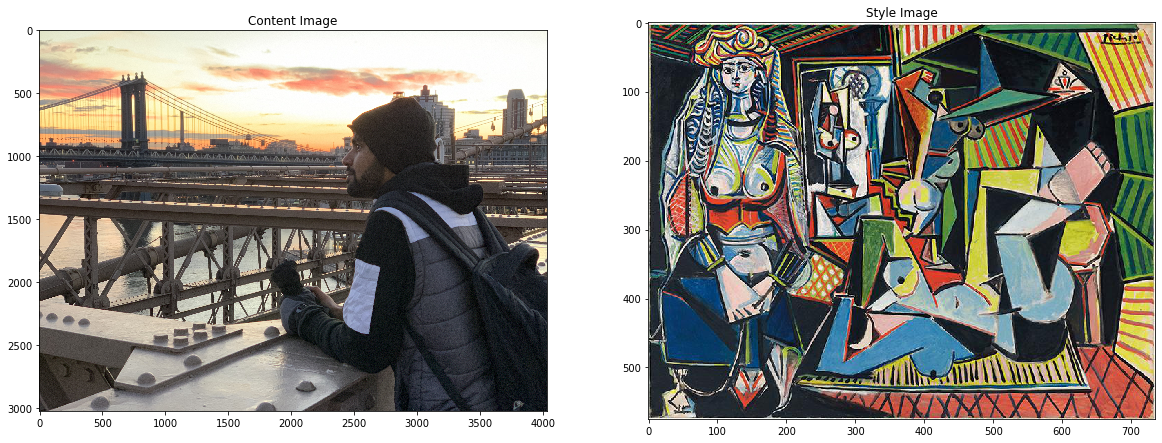

In [5]:
content = plt.imread('Input/Content.jpg')
style = plt.imread('Input/Style2.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')

In [6]:
def normalize_image(image):
    means = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, (image_width, image_height))
    # Reshape image to mach expected input of VGG19
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - means
    
    return image

In [7]:
content_image = normalize_image(content)
style_image = normalize_image(style)

W0814 22:12:45.452157  9416 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0814 22:12:45.462166  9416 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Normalized Style Image')

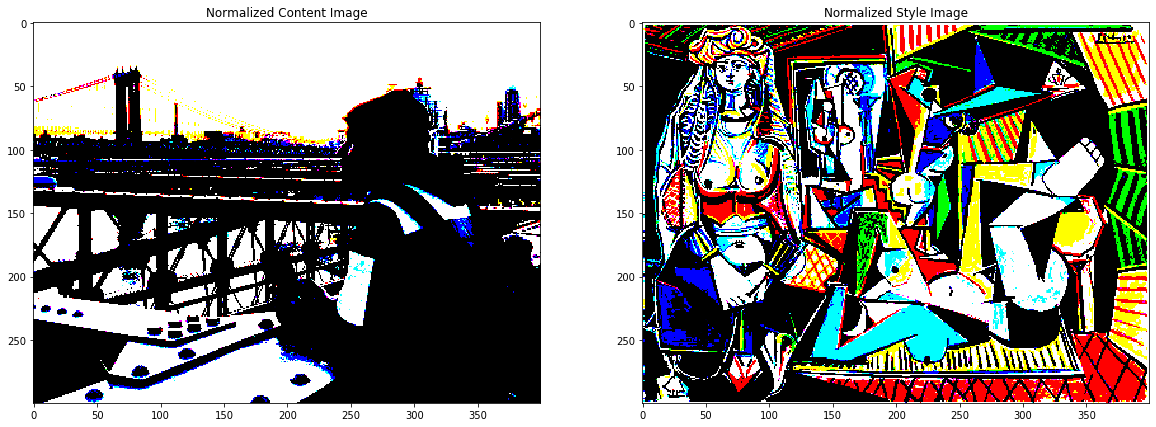

In [8]:
# DIsplay the normalized images

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(content_image[0])
ax1.set_title('Normalized Content Image')
ax2.imshow(style_image[0])
ax2.set_title('Normalized Style Image')

In [9]:
def generate_noise_image(content_image, noise_ratio = 0.6):
    # Generates a noisy image by adding random noise to the content_image
    

    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (image_height, image_width, color_channels)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image.
    # Easier for the optimization algorithm to converge to the solution
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

W0814 22:12:46.531769  9416 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Generated noisy image')

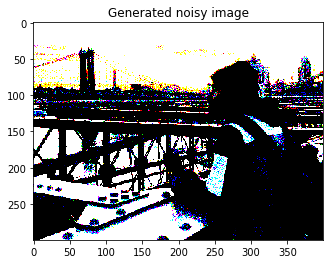

In [10]:
img = generate_noise_image(content_image)
plt.imshow(img[0])
plt.title('Generated noisy image')

## Content Loss

### Equation

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

where,

* $J_{content}(C,G)$ - content loss

* $a^{(C)}, a^{(G)}$ - hidden layer activations of the content image and generated image respectively 

* (1, n_H, n_W, n_C) - Shape of the tensors $a^{(C)}\,\,\text{and}\,\, a^{(G)}$



In [11]:
# Compute the content cost
def content_cost(act_con, act_gen):
    """
    act_con - hidden layer activation of the content image input (tensor)
    act_gen - hidden layer activation of the generated image input (tensor)
    """
       
    m, n_H, n_W, n_C = act_gen.get_shape().as_list()
    
    act_con_unrolled = tf.reshape(act_con, [n_C, -1])
    act_gen_unrolled = tf.reshape(act_gen, [n_C, -1])
    
    content_loss = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(act_con_unrolled, act_gen_unrolled)))
    
    return content_loss

## Style cost

### Gram/ Style matrix

* Gram or Style matrix is a matrix of shape (n_c, n_c) where n_c is the numer of channels. It gives the unnormalized correlation between the various channels of the activations 

* We reshape the activations (of shape (1, n_H, n_W, n_C)) to (n_C, n_H*n_W) and take a dot product of this matrix to get the style matrix of shape (n_C, n_C)

In [12]:
def gram_matrix(A):
    gram_A = tf.matmul(A, tf.transpose(A))
    return gram_A

**Formula**

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where,

* $J_{style}^{[l]}(S,G)$ - style loss for the layer l, S is the style image and G is the generated image

* $G^{(S)}, G^{(G)}$ - Gram matrix of the style and generated image respectively


In [13]:
def layer_style_cost(act_style, act_gen):
    m, n_H, n_W, n_C = act_style.get_shape().as_list()
    
    act_style = tf.reshape(act_style, [n_H*n_W, n_C])
    act_gen = tf.reshape(act_gen, [n_H*n_W, n_C])
    
    GS = gram_matrix(tf.transpose(act_style))
    GG = gram_matrix(tf.transpose(act_gen))
    
    J_style_layer = (1/(2*n_C*n_H*n_W)**2)*tf.reduce_sum(tf.square(tf.subtract(GG, GS)))
    return J_style_layer

Style cost works better if we use multiple layers to calculate it.

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$


In [14]:
# Defining the style layers (from the graph in vgg_model.py based on vgg19 model) and their weights
style_layers = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [15]:
# Compute the total style loss

def style_cost(model, style_layers):

    # initialize the overall style cost
    style_loss = 0

    for layer_name, coeff in style_layers:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set act_style to be the hidden layer activation from the layer we have selected, by running the session on out
        act_style = sess.run(out)
        act_style = tf.convert_to_tensor(act_style)

        # Set act_gen to be the hidden layer activation from same layer.
        # When the input image is G, the activations will be drawn from the appropriate layer
        act_gen = out
        
        # Compute style_cost for the current layer
        style_loss_layer = layer_style_cost(act_style, act_gen)

        style_loss += coeff * style_loss_layer

    return style_loss

In [16]:
# Total loss (including style and content loss)

def total_cost(content_loss, style_loss, alpha = 10, beta = 50):    
   
    total_loss = alpha*content_loss + beta*style_loss
    
    return total_loss

In [17]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession(config=config)

In [18]:
# Load the model using the vgg_model.py script from the .mat file

model = load_vgg_model("imagenet-vgg-verydeep-19.mat")


W0814 22:13:06.910135  9416 deprecation_wrapper.py:119] From D:\Summer stuff\Deep Learning\Projects\Neural_Style_Transfer\vgg_model.py:58: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [19]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer selected
content_activation = sess.run(out)

# Set act_gen to be the hidden layer activation from same layer. 
generated_activation = out

# Compute the content cost
J_content = content_cost(content_activation, generated_activation)

In [20]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = style_cost(model, style_layers)

In [21]:
# Total cost
J = total_cost(J_content, J_style)


In [22]:
# Optimizer and train step
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [23]:
def save_final_image(path, image):
    means = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

    # Un-normalize the image so that it looks good
    image = image + means
    
    image = np.clip(image[0], 0, 255).astype('uint8') # Make sure the pixel values are between 0 and 255
    cv2.imwrite(path, image)

In [24]:
def model_nst(sess, input_image, num_iterations = 1200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model.
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 50 iteration.
        if i%50 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
    
    # save last generated image
    save_final_image('Output/generated_image2.jpg', generated_image)
    
    return generated_image

In [25]:
GI = model_nst(sess, img)

Iteration 0 :
total cost = 33000817000.0
content cost = 10157.658
style cost = 660014300.0
Iteration 50 :
total cost = 1265984000.0
content cost = 26743.172
style cost = 25314332.0
Iteration 100 :
total cost = 504537820.0
content cost = 27362.06
style cost = 10085284.0
Iteration 150 :
total cost = 313791800.0
content cost = 27820.582
style cost = 6270272.0
Iteration 200 :
total cost = 231311000.0
content cost = 28264.283
style cost = 4620567.5
Iteration 250 :
total cost = 185420370.0
content cost = 28678.172
style cost = 3702671.8
Iteration 300 :
total cost = 155008220.0
content cost = 29051.84
style cost = 3094354.2
Iteration 350 :
total cost = 133196744.0
content cost = 29362.846
style cost = 2658062.2
Iteration 400 :
total cost = 116431096.0
content cost = 29636.307
style cost = 2322694.8
Iteration 450 :
total cost = 103134130.0
content cost = 29877.045
style cost = 2056707.1
Iteration 500 :
total cost = 92373830.0
content cost = 30087.574
style cost = 1841459.2
Iteration 550 :
tota

W0814 22:15:50.954345  9416 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


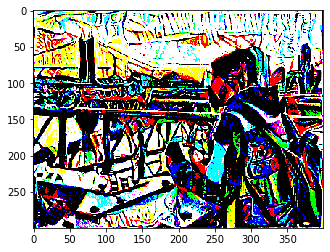

In [26]:
plt.imshow(GI[0])

In [27]:
cv2.imwrite('Output/normalized_generated_image2.jpg', GI[0])

True